## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import warnings
import datetime as dt
import pytz as tz
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sqlalchemy import create_engine
import xgboost as xgb
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix


In [2]:
# Ignore the warnings
warnings.simplefilter('ignore')

## Load training and prediction window data from saved sql databases

In [3]:
engine =create_engine('sqlite:///Earthquakedata.db')
df_features = pd.read_sql_table('Earthquake_features',con=engine)

In [4]:
df_features.head()

,date,depth,mag,place,latitude,longitude,depth_avg_22,depth_avg_15,depth_avg_7,mag_avg_22,mag_avg_15,mag_avg_7,mag_outcome
0,2022-11-06,7.2,0.8,California,39.251735,-119.621585,5.845455,6.946667,9.228571,0.672727,0.720000,0.771429,0
1,2022-11-08,12.1,1.7,California,39.251735,-119.621585,6.345455,7.206667,9.314286,0.718182,0.846667,0.842857,0
2,2022-11-08,4.9,0.8,California,39.251735,-119.621585,6.477273,7.533333,8.642857,0.709091,0.820000,0.914286,0
3,2022-11-08,6.1,0.7,California,39.251735,-119.621585,6.531818,7.940000,8.100000,0.727273,0.833333,1.028571,0
4,2022-11-08,4.3,0.3,California,39.251735,-119.621585,6.650000,8.173333,7.500000,0.736364,0.773333,1.028571,0


In [5]:
engine =create_engine('sqlite:///Earthquakedata_predict.db')
df_predict = pd.read_sql_table('Earthquake_predict',con=engine)

In [6]:
# Live data to be predicted on after being trained of rolling period for next 7 days. 
#Hence NaN outcome that has to be predicted

df_predict.head()

,date,depth,mag,place,latitude,longitude,depth_avg_22,depth_avg_15,depth_avg_7,mag_avg_22,mag_avg_15,mag_avg_7,mag_outcome
0,2022-11-26,4.0,2.6,California,39.251735,-119.621585,7.500000,6.780000,7.500000,0.931818,0.800000,0.871429,NaN
1,2022-11-26,11.3,0.5,California,39.251735,-119.621585,7.731818,6.993333,9.071429,0.868182,0.866667,0.842857,NaN
2,2022-11-28,3.1,0.8,California,39.251735,-119.621585,7.077273,6.666667,8.014286,0.850000,0.853333,0.900000,NaN
3,2022-11-28,4.8,0.8,California,39.251735,-119.621585,6.931818,6.573333,7.157143,0.854545,0.866667,0.957143,NaN
4,2022-11-29,10.0,2.5,California,39.251735,-119.621585,6.954545,7.240000,7.371429,0.909091,0.946667,1.214286,NaN


**Training is done by considering 22,15 & 7 days window past features rolling average and outcome data is shifted to next 7 Days.**

In [7]:
# Selection of features that are needed for prediction and hence consider only them rest are just ignored for prediction purpose.

features = [f for f in list(df_features) if f not in ['date', 'lon_box_mean',
 'lat_box_mean', 'mag_outcome', 'mag', 'place',
 'combo_box_mean',  'latitude',
 'longitude']]

# splitting traing and testing dataset with trainging size = 70% and test = 30%
X_train, X_test, y_train, y_test = train_test_split(df_features[features],
                     df_features['mag_outcome'], test_size=0.3, random_state=42)

In [8]:
features

['depth',
 'depth_avg_22',
 'depth_avg_15',
 'depth_avg_7',
 'mag_avg_22',
 'mag_avg_15',
 'mag_avg_7']

## Machine Learning & Boosting algorithms

### Decision Tree with Ada Boost Classifier

In [9]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
              "base_estimator__max_depth" :   [2,5,7],
              "n_estimators": [200, 400, 600]
             }

# base estimator
tree = DecisionTreeClassifier()

# adaboost with the tree as base estimator
# learning rate is arbitrarily set to 0.6,
ABC = AdaBoostClassifier(
    base_estimator=tree,
    learning_rate=0.6,
    algorithm="SAMME")

In [10]:
# run grid search
grid_search_ABC = GridSearchCV(ABC,
                               param_grid=param_grid, 
                               scoring = 'roc_auc', 
                               return_train_score=True,                         
                               verbose = 1)

In [11]:
grid_search_ABC.fit(X_train,y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(estimator=AdaBoostClassifier(algorithm='SAMME',
                                          base_estimator=DecisionTreeClassifier(),
                                          learning_rate=0.6),
             param_grid={'base_estimator__max_depth': [2, 5, 7],
                         'n_estimators': [200, 400, 600]},
             return_train_score=True, scoring='roc_auc', verbose=1)

In [12]:
pred_ABC=grid_search_ABC.predict(X_test)

0.8483985311996846
AUC: 0.8484


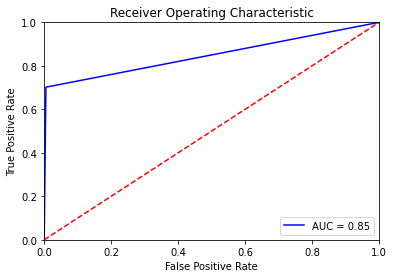

In [13]:

print(roc_auc_score(y_test, pred_ABC))

fpr, tpr, _ = roc_curve(y_test, pred_ABC)
roc_auc = auc(fpr, tpr)
print('AUC:', np.round(roc_auc,4))

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Confusion Matrix 
 [[2329   12]
 [  31   73]]
Confusion Matrix 
 [[2329   31]
 [  12   73]]

Recall TP/TP+FN =  0.7019230769230769


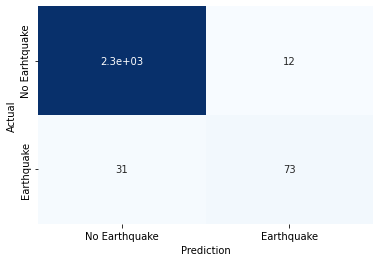

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
print('Confusion Matrix \n',confusion_matrix(y_test,pred_ABC))
print('Confusion Matrix \n',confusion_matrix(pred_ABC,y_test))
confusion_matrix= confusion_matrix(y_test,pred_ABC)
hm = sns.heatmap(confusion_matrix, annot=True, xticklabels=['No Earthquake', 'Earthquake'], 
                 yticklabels=['No Earhtquake', 'Earthquake'], 
                 cbar=False, cmap='Blues')
hm.set_xlabel("Prediction")
hm.set_ylabel("Actual")
hm
dtc=recall_score(y_test,pred_ABC)
print("\nRecall TP/TP+FN = ",dtc)

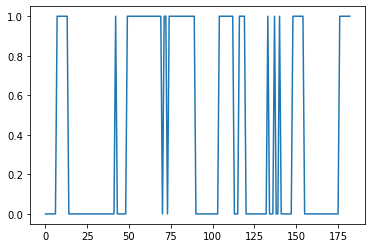

In [15]:
pred_ABC=grid_search_ABC.predict(df_predict[features])
plt.plot(pred_ABC)
plt.show()

In [16]:
live_set = df_predict[['date', 'place', 'latitude', 'longitude']]
live_set.loc[:,'quake'] = pred_ABC
# aggregate down dups
live_set = live_set.groupby(['date', 'place'], as_index=False).mean()

# increment date to include DAYS_OUT_TO_PREDICT
live_set['date']= pd.to_datetime(live_set['date'],format='%Y-%m-%d') 
live_set['date'] = live_set['date'] + pd.to_timedelta(7,unit='days')

live_set

,date,place,latitude,longitude,quake
0,2022-11-25,Papua New Guinea,-5.524528,149.714707,1.0
1,2022-11-27,Papua New Guinea,-5.524528,149.714707,1.0
2,2022-11-28,Montana,44.863002,-111.066538,0.0
3,2022-11-28,Papua New Guinea,-5.524528,149.714707,1.0
4,2022-11-28,Tonga,-18.591112,-174.017210,1.0
...,...,...,...,...,...
87,2022-12-07,Puerto Rico,18.114459,-66.833591,0.0
88,2022-12-07,Russia,52.017591,130.222957,1.0
89,2022-12-07,Texas,31.575240,-103.698497,0.5
90,2022-12-07,U.S. Virgin Islands,19.030958,-64.815751,1.0


In [17]:
# convert date to proper format for prediction
days = list(set([d for d in live_set['date'].astype(str) if d > dt.datetime.now(tz.timezone('US/Central')).strftime('%Y-%m-%d')]))
days.sort()

# Predict NaN outcome value in earthquake for next day 1.
predict_day=days[0]
predict_day

'2022-12-01'

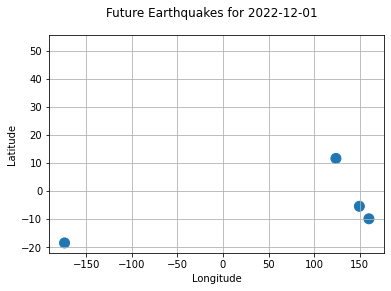

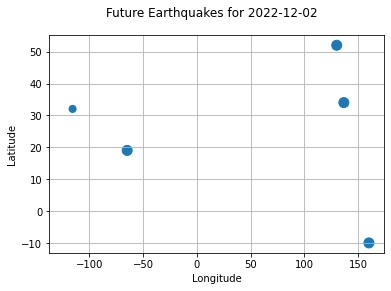

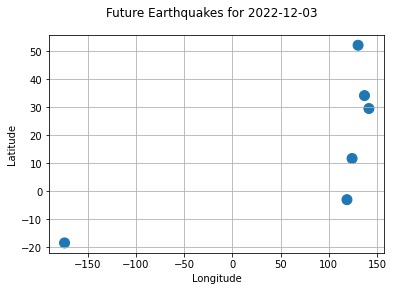

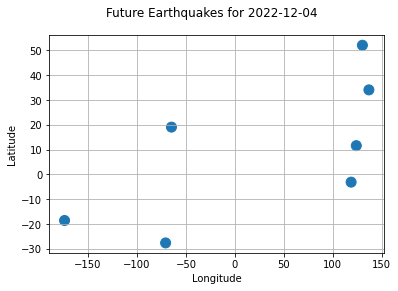

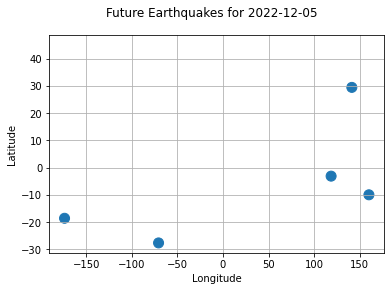

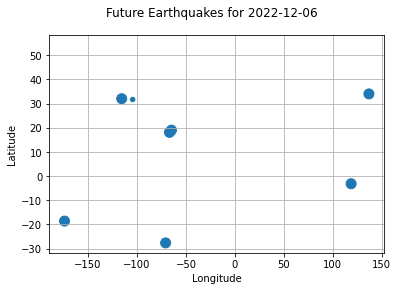

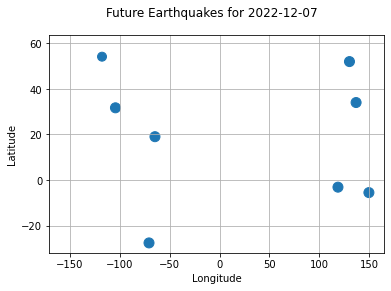

In [18]:
# place, date, lat and long with earthquake probability for next 7 days
for i in range(0,7):
    live_set_tmp = live_set[live_set['date'] == days[i]]
    plt.scatter(live_set_tmp['longitude'], live_set_tmp['latitude'], s=(live_set_tmp['quake'] * 100))
    plt.suptitle('Future Earthquakes for ' + days[i])
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid()
    plt.show()

In [19]:
live_set.to_csv('dt_live_dataset.csv',index=False)

### Random Forest Classifier

In [20]:
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_jobs=-1,max_features= 'sqrt' ,n_estimators=50, oob_score = True) 

param_grid = { 
    'n_estimators': [200, 700],
    'max_features': ['auto', 'sqrt', 'log2']
}
# GridSearch of parameter tunning.
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(max_features='sqrt',
                                              n_estimators=50, n_jobs=-1,
                                              oob_score=True),
             param_grid={'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [200, 700]})

In [21]:
pred=CV_rfc.predict(X_test)

0.8107913284920975
AUC: 0.8108


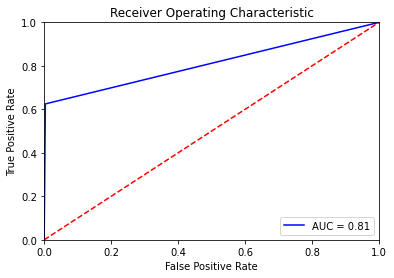

In [22]:
print(roc_auc_score(y_test, pred))

fpr, tpr, _ = roc_curve(y_test, pred)
roc_auc = auc(fpr, tpr)
print('AUC:', np.round(roc_auc,4))

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


Confusion Matrix 
 [[2333    8]
 [  39   65]]
Confusion Matrix 
 [[2333   39]
 [   8   65]]

Recall 'TP/TP+FN' =  0.625


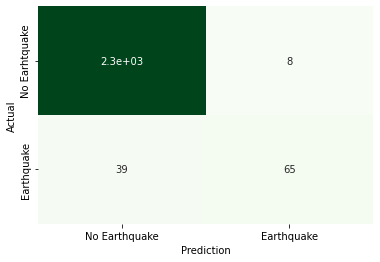

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
print('Confusion Matrix \n',confusion_matrix(y_test,pred))
print('Confusion Matrix \n',confusion_matrix(pred,y_test))
confusion_matrix= confusion_matrix(y_test,pred)
hm = sns.heatmap(confusion_matrix, annot=True, xticklabels=['No Earthquake', 'Earthquake'], 
                 yticklabels=['No Earhtquake', 'Earthquake'],
                 cbar=False, cmap='Greens')
hm.set_xlabel("Prediction")
hm.set_ylabel("Actual")
hm
rfc=recall_score(y_test,pred)
print("\nRecall 'TP/TP+FN' = ", rfc)

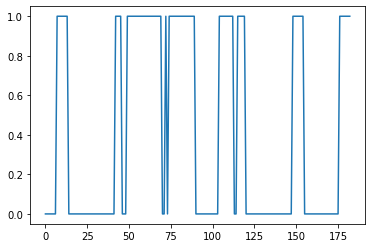

In [24]:
pred=CV_rfc.predict(df_predict[features])
plt.plot(pred)
plt.show()

In [25]:
live_set = df_predict[['date', 'place', 'latitude', 'longitude']]
live_set.loc[:,'quake'] = pred
# aggregate down dups
live_set = live_set.groupby(['date', 'place'], as_index=False).mean()

# increment date to include DAYS_OUT_TO_PREDICT
live_set['date']= pd.to_datetime(live_set['date'],format='%Y-%m-%d') 
live_set['date'] = live_set['date'] + pd.to_timedelta(7,unit='d')
live_set.tail()

,date,place,latitude,longitude,quake
87,2022-12-07,Puerto Rico,18.114459,-66.833591,0.5
88,2022-12-07,Russia,52.017591,130.222957,1.0
89,2022-12-07,Texas,31.575240,-103.698497,0.0
90,2022-12-07,U.S. Virgin Islands,19.030958,-64.815751,1.0
91,2022-12-07,Utah,40.225939,-112.244823,0.0


In [26]:
# convert date to proper format for prediction
days = list(set([d for d in live_set['date'].astype(str) if d > dt.datetime.now(tz.timezone('US/Central')).strftime('%Y-%m-%d')]))
days.sort()

# Predict NaN outcome value in earthquake for next day 1.
predict_day=days[0]
predict_day

'2022-12-01'

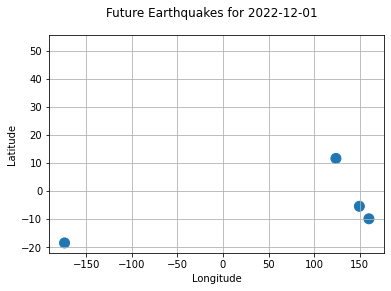

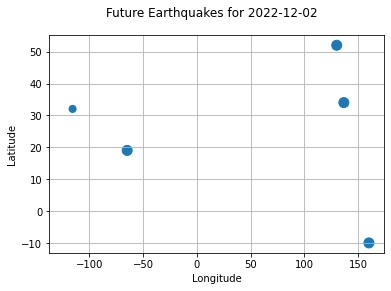

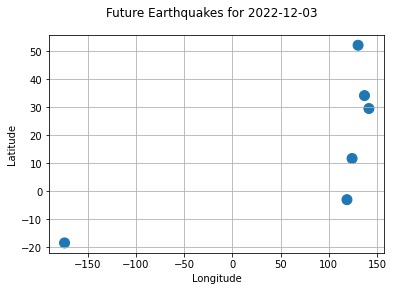

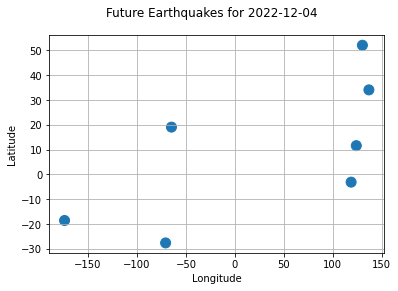

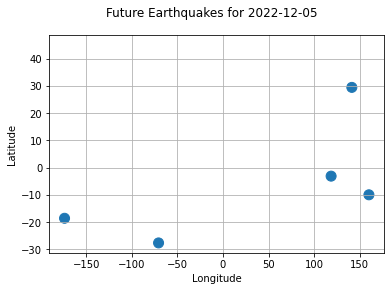

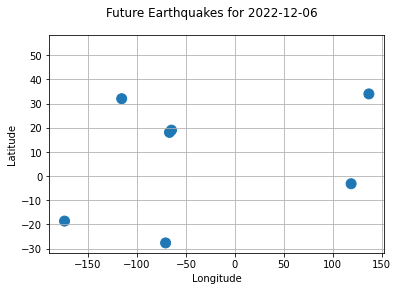

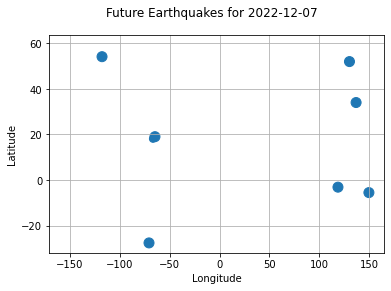

In [27]:
# place, date, lat and long with earthquake probability for next 7 days
for i in range(0,7):
    live_set_tmp = live_set[live_set['date'] == days[i]]
    plt.scatter(live_set_tmp['longitude'], live_set_tmp['latitude'], s=(live_set_tmp['quake'] * 100))
    plt.suptitle('Future Earthquakes for ' + days[i])
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid()
    plt.show()


In [28]:
live_set.to_csv('rfc_live_dataset.csv',index=False)

### XGBoost Algorithm

In [29]:
from xgboost import XGBClassifier
import xgboost as xgb

dtrain = xgb.DMatrix(X_train[features], label=y_train)
dtest = xgb.DMatrix(X_test[features], label=y_test)

param = {
        'objective': 'binary:logistic',
        'booster': 'gbtree',
        'eval_metric': 'auc',
        'max_depth': 6,  # the maximum depth of each tree
        'eta': 0.003,  # the training step for each iteration
        'silent': 1}  # logging mode - quiet}  # the number of classes that exist in this datset
num_round = 5000  # the number of training iterations    
bst = xgb.train(param, dtrain, num_round)
preds = bst.predict(dtest)


[23:57:05] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




In [30]:
ypred_bst = np.array(bst.predict(dtest,ntree_limit=bst.best_iteration))
ypred_bst  = ypred_bst > 0.5
ypred_bst = ypred_bst.astype(int)  

0.9854064666644761
AUC: 0.9854


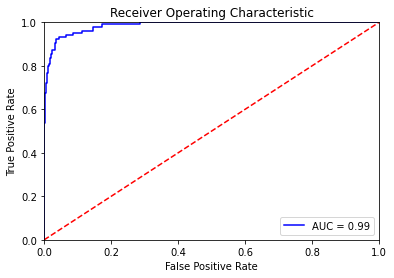

In [31]:

print (roc_auc_score(y_test, preds))
fpr, tpr, _ = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)
print('AUC:', np.round(roc_auc,4))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


Confusion Matrix 
 [[2328   13]
 [  30   74]]
Confusion Matrix 
 [[2328   30]
 [  13   74]]

Recall 'TP/TP+FN' =  0.7115384615384616


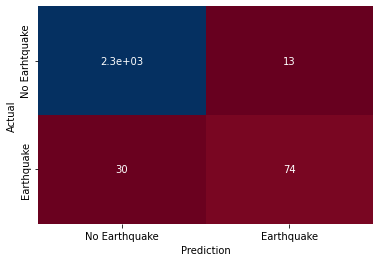

In [32]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
print('Confusion Matrix \n',confusion_matrix(y_test,ypred_bst))
print('Confusion Matrix \n',confusion_matrix(ypred_bst,y_test))
confusion_matrix= confusion_matrix(y_test,ypred_bst)
hm = sns.heatmap(confusion_matrix, annot=True, xticklabels=['No Earthquake', 'Earthquake'], 
                 yticklabels=['No Earhtquake', 'Earthquake'],
                 cbar=False, cmap='RdBu')
hm.set_xlabel("Prediction")
hm.set_ylabel("Actual")
xgbc=recall_score(y_test,ypred_bst)
print("\nRecall 'TP/TP+FN' = ", xgbc)

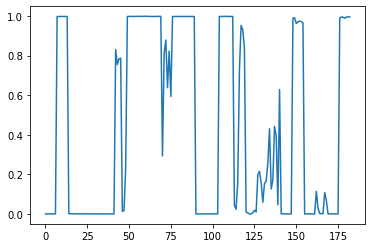

In [33]:
dlive = xgb.DMatrix(df_predict[features]) #, label=[])
preds = bst.predict(dlive)

plt.plot(preds)
plt.show()

In [34]:
live_set = df_predict[['date', 'place', 'latitude', 'longitude']]
live_set.loc[:,'quake'] = preds
# aggregate down dups
live_set = live_set.groupby(['date', 'place'], as_index=False).mean()

# increment date to include DAYS_OUT_TO_PREDICT
live_set['date']= pd.to_datetime(live_set['date'],format='%Y-%m-%d') 
live_set['date'] = live_set['date'] + pd.to_timedelta(7,unit='d')

live_set.tail()

,date,place,latitude,longitude,quake
87,2022-12-07,Puerto Rico,18.114459,-66.833591,0.431800
88,2022-12-07,Russia,52.017591,130.222957,0.997943
89,2022-12-07,Texas,31.575240,-103.698497,0.210647
90,2022-12-07,U.S. Virgin Islands,19.030958,-64.815751,0.995819
91,2022-12-07,Utah,40.225939,-112.244823,0.000064


In [35]:
# convert date to proper format for prediction
days = list(set([d for d in live_set['date'].astype(str) if d > dt.datetime.now(tz.timezone('US/Central')).strftime('%Y-%m-%d')]))
days.sort()

# Predict NaN outcome value in earthquake for next day 1.
predict_day=days[0]
predict_day

'2022-12-01'

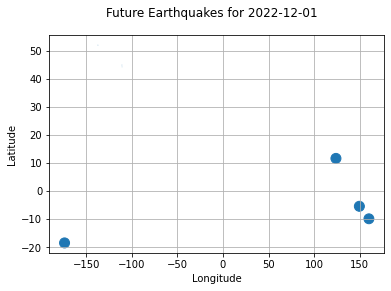

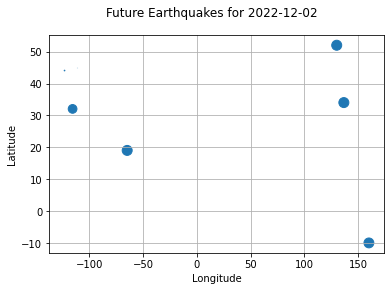

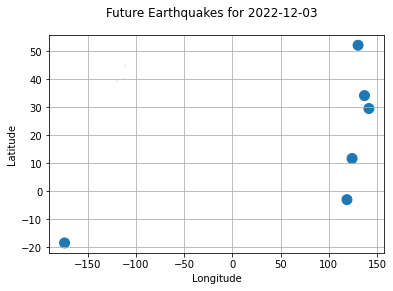

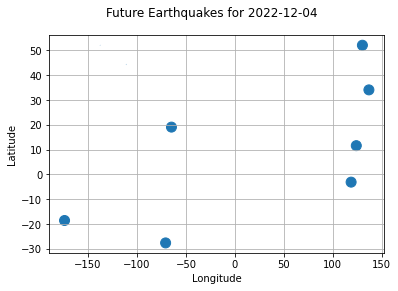

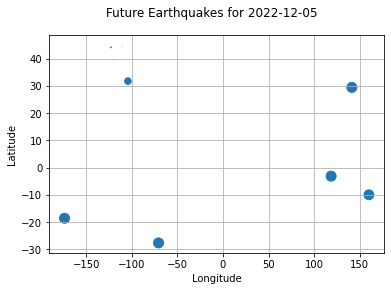

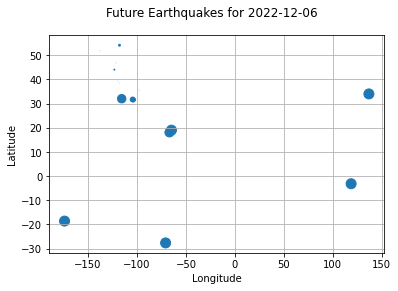

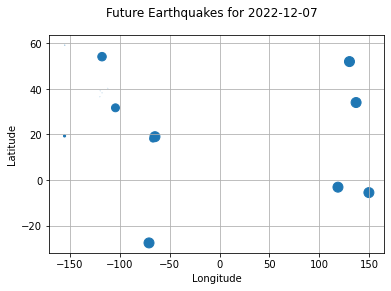

In [36]:
# place, date, lat and long with earthquake probability for next 7 days
for i in range(0,7):
    live_set_tmp = live_set[live_set['date'] == days[i]]
    plt.scatter(live_set_tmp['longitude'], live_set_tmp['latitude'], s=(live_set_tmp['quake'] * 100))
    plt.suptitle('Future Earthquakes for ' + days[i])
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid()
    plt.show()

In [37]:
live_set.to_csv('xgb_live_dataset.csv',index=False)

### Multi-Layer Precepton

In [38]:
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
# Input layer
model.add(Dense(32, activation='relu', input_dim=len(features)))
# Hidden Layer
model.add(Dense(16, activation='relu'))
# Output Layer
model.add(Dense(1, activation='sigmoid'))
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [39]:
#Train the model
model.fit(X_train,y_train,epochs=200,verbose=False);

In [40]:
pred_mlp=(model.predict(X_test) > 0.5).astype("int32")

ROC_AUC_Score:  0.7716890382150955
AUC:  0.7717


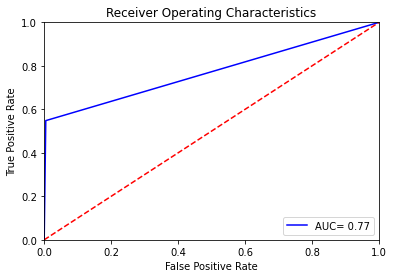

In [41]:
print("ROC_AUC_Score: ",roc_auc_score(y_test,pred_mlp))
fpr,tpr,_= roc_curve(y_test,pred_mlp)
roc_auc=auc(fpr,tpr)
print('AUC: ',np.round(roc_auc,4))

plt.title('Receiver Operating Characteristics')
plt.plot(fpr,tpr,'b',label='AUC= %0.2f'%roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Confusion Matrix 
 [[2330   11]
 [  47   57]]
Confusion Matrix 
 [[2330   47]
 [  11   57]]

Recall TP/TP+FN =  0.5480769230769231


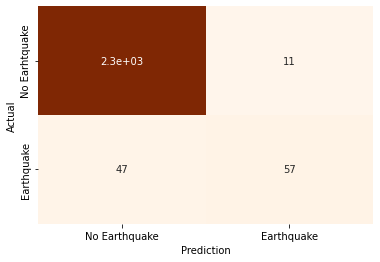

In [42]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
print('Confusion Matrix \n',confusion_matrix(y_test,pred_mlp))
print('Confusion Matrix \n',confusion_matrix(pred_mlp,y_test))
confusion_matrix= confusion_matrix(y_test,pred_mlp)
hm = sns.heatmap(confusion_matrix, annot=True, xticklabels=['No Earthquake', 'Earthquake'], 
                 yticklabels=['No Earhtquake', 'Earthquake'],
                 cbar=False, cmap='Oranges')
hm.set_xlabel("Prediction")
hm.set_ylabel("Actual")
hm
mlpc=recall_score(y_test,pred_mlp)
print("\nRecall TP/TP+FN = ",mlpc)

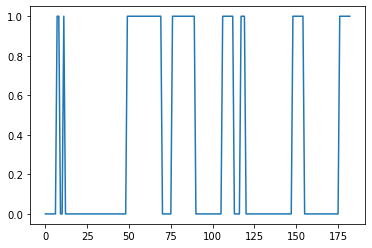

In [43]:
pred_mlp=(model.predict(df_predict[features]) > 0.5).astype("int32")
plt.plot(pred_mlp)
plt.show()

In [44]:
live_set = df_predict[['date', 'place', 'latitude', 'longitude']]
live_set.loc[:,'quake'] = pred_mlp
# aggregate down dups
live_set = live_set.groupby(['date', 'place'], as_index=False).mean()

# increment date to include DAYS_OUT_TO_PREDICT 
live_set['date']= pd.to_datetime(live_set['date'],format='%Y-%m-%d') 
live_set['date'] = live_set['date'] + pd.to_timedelta(7,unit='d')

live_set.tail()

,date,place,latitude,longitude,quake
87,2022-12-07,Puerto Rico,18.114459,-66.833591,0.0
88,2022-12-07,Russia,52.017591,130.222957,1.0
89,2022-12-07,Texas,31.575240,-103.698497,0.0
90,2022-12-07,U.S. Virgin Islands,19.030958,-64.815751,1.0
91,2022-12-07,Utah,40.225939,-112.244823,0.0


In [45]:
# convert date to proper format for prediction
days = list(set([d for d in live_set['date'].astype(str) if d > dt.datetime.now(tz.timezone('US/Central')).strftime('%Y-%m-%d')]))
days.sort()

# Predict NaN outcome value in earthquake for next day 1.
predict_day=days[0]
predict_day

'2022-12-01'

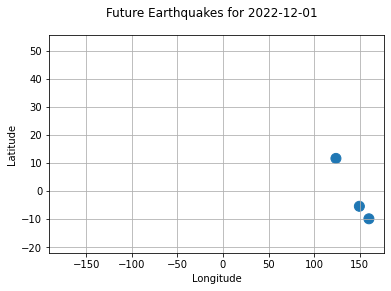

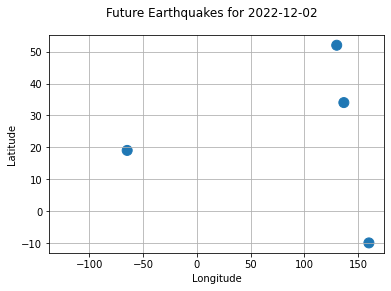

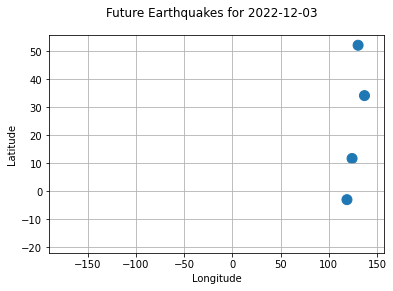

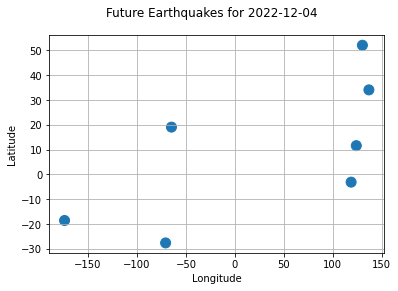

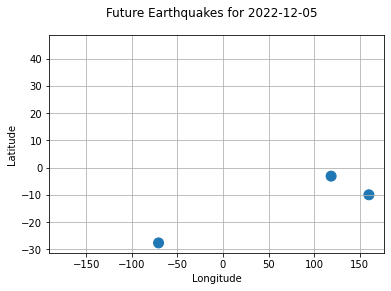

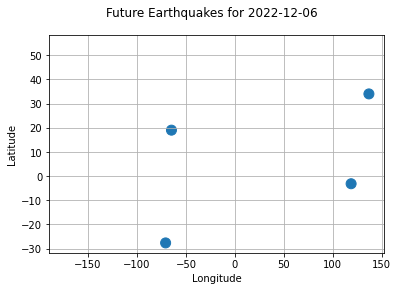

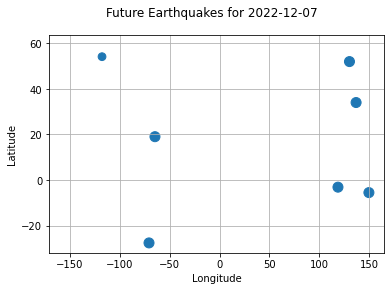

In [46]:
# place, date, lat and long with earthquake probability for next 7 days
for i in range(0,7):
    live_set_tmp = live_set[live_set['date'] == days[i]]
    plt.scatter(live_set_tmp['longitude'], live_set_tmp['latitude'], s=(live_set_tmp['quake'] * 100))
    plt.suptitle('Future Earthquakes for ' + days[i])
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid()
    plt.show()


In [47]:
live_set.to_csv('mlp_live_dataset.csv',index=False)

## Comparing models and find the best outcome

In [48]:

best_recall=max([dtc,rfc,xgbc,mlpc])
print("Recall (Sensitivity): ",best_recall)

Recall (Sensitivity):  0.7115384615384616


In [49]:
import datetime as dt
def live_prediction(x):
    if x== dtc:
        pred=grid_search_ABC.predict(df_predict[features])
    elif x==rfc:
        pred=CV_rfc.predict(df_predict[features])
    elif x==xgbc:
        dlive = xgb.DMatrix(df_predict[features]) #, label=[])
        pred = bst.predict(dlive)
    elif x==mlpc:
        pred=(model.predict(df_predict[features]) > 0.5).astype("int32")
    plt.plot(pred)
    plt.show()
    
    live_set = df_predict[['date', 'place', 'latitude', 'longitude']]
    live_set.loc[:,'quake'] = pred
    # aggregate down dups
    live_set = live_set.groupby(['date', 'place'], as_index=False).mean()

    # increment date to include DAYS_OUT_TO_PREDICT
    live_set['date']= pd.to_datetime(live_set['date'],format='%Y-%m-%d') 
    live_set['date'] = live_set['date'] + pd.to_timedelta(7,unit='d')

    live_set.tail()
    
    # convert date to proper format for prediction
    days = list(set([d for d in live_set['date'].astype(str) if d > dt.datetime.now(tz.timezone('US/Central')).strftime('%Y-%m-%d')]))
    days.sort()

    # Predict NaN outcome value in earthquake for next day 1.
    predict_day=days[0]
    predict_day
    
    # place, date, lat and long with earthquake probability for next 7 days
    for i in range(0,7):
        live_set_tmp = live_set[live_set['date'] == days[i]]
        plt.scatter(live_set_tmp['longitude'], live_set_tmp['latitude'], s=(live_set_tmp['quake'] * 100))
        plt.suptitle('Future Earthquakes for ' + days[i])
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        plt.grid()
        plt.show()
    
    live_set.to_csv('best_recall_live_dataset.csv',index=False)

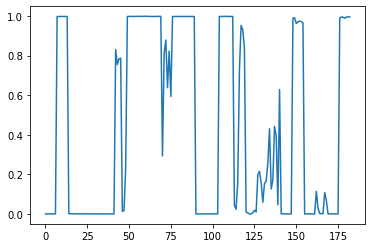

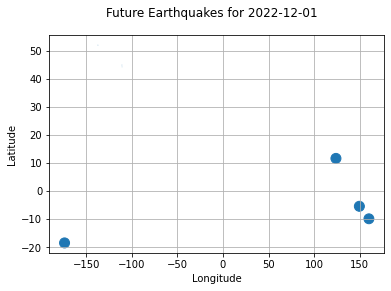

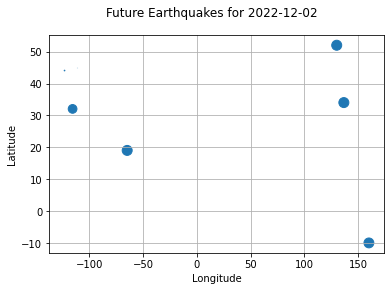

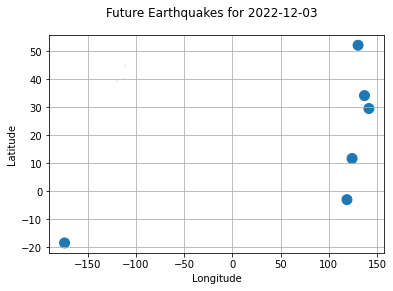

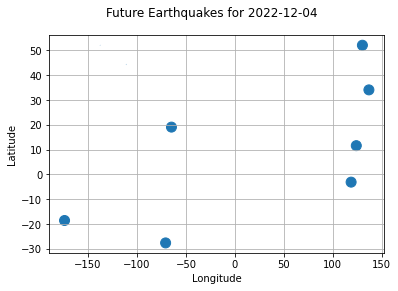

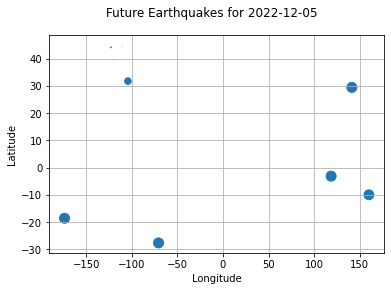

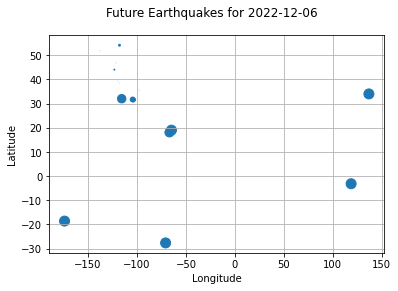

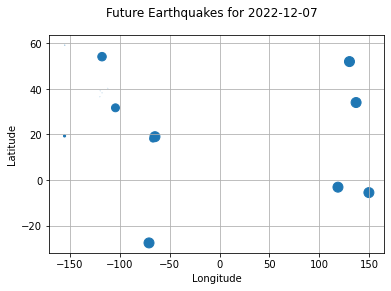

In [50]:
live_prediction(best_recall)